<a href="https://colab.research.google.com/github/EstefaniaOsmaLlanes/CLASIFICACI-N-DE-TUMORES-CEREBRALES-A-PARTIR-DE-IMAGENES-DE-RESONANCIA-MAGNETICA_IA2/blob/main/BASE_PROYECTO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

In [3]:
#@title Imports
import os
import gc
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Dataset**

In [ ]:
import os
import zipfile
os.makedirs('/root/.kaggle/', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d rm1000/brain-tumor-mri-scans
with zipfile.ZipFile('brain-tumor-mri-scans.zip', 'r') as zip_ref:
    zip_ref.extractall('brain_tumor_mri_scans')

Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
License(s): CC0-1.0
100% 236M/236M [00:03<00:00, 29.3MB/s]
100% 236M/236M [00:03<00:00, 62.7MB/s]


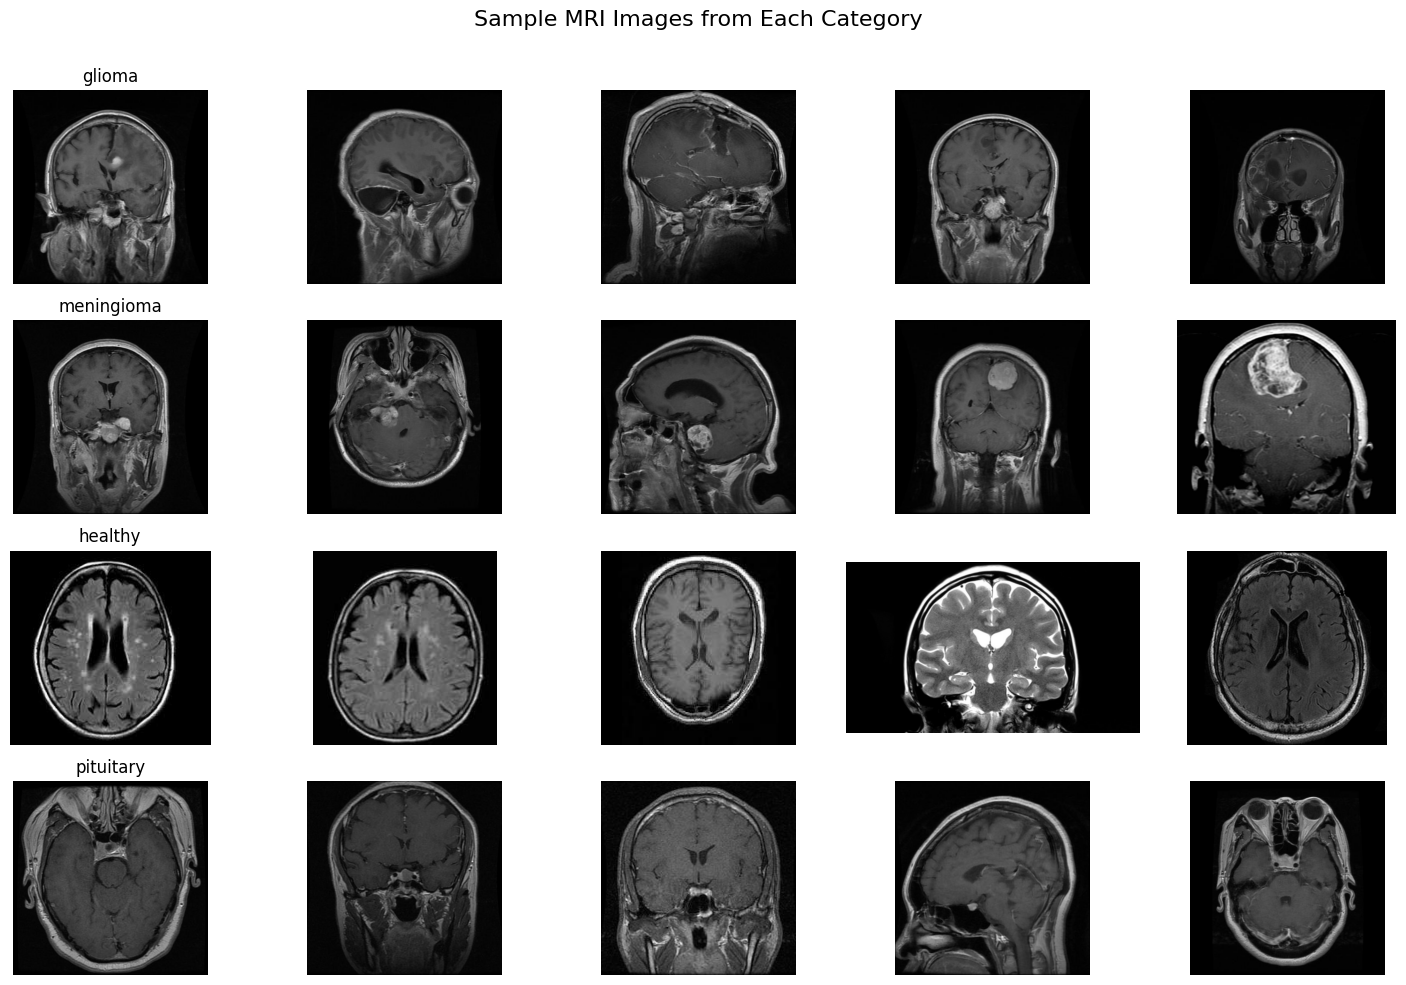

In [ ]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

base_dir = 'brain_tumor_mri_scans'
categories = ['glioma', 'meningioma', 'healthy', 'pituitary']

num_images = 5

fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 10))
fig.suptitle("Sample MRI Images from Each Category", fontsize=16)

for i, category in enumerate(categories):
    category_path = os.path.join(base_dir, category)
    images = os.listdir(category_path)

    selected_images = random.sample(images, num_images)

    for j, img_name in enumerate(selected_images):
        img_path = os.path.join(category_path, img_name)
        img = Image.open(img_path)

        ax = axes[i, j]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(category if j == 0 else "")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
import os
import cv2
import numpy as np

base_dir = 'brain_tumor_mri_scans'
categories = ['glioma', 'meningioma', 'healthy', 'pituitary']
image_size = (128, 128)

x_train = []
y_train = []

for i, category in enumerate(categories):
  category_path = os.path.join(base_dir, category)
  for filename in os.listdir(category_path):
    img_path = os.path.join(category_path, filename)
    try:
      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img, image_size)
      x_train.append(img)
      y_train.append(i)
    except Exception as e:
      print(f"Error processing image {img_path}: {e}")

x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = x_train.reshape(-1, image_size[0], image_size[1], 1)
x_train = x_train.astype('float32') / 255.0

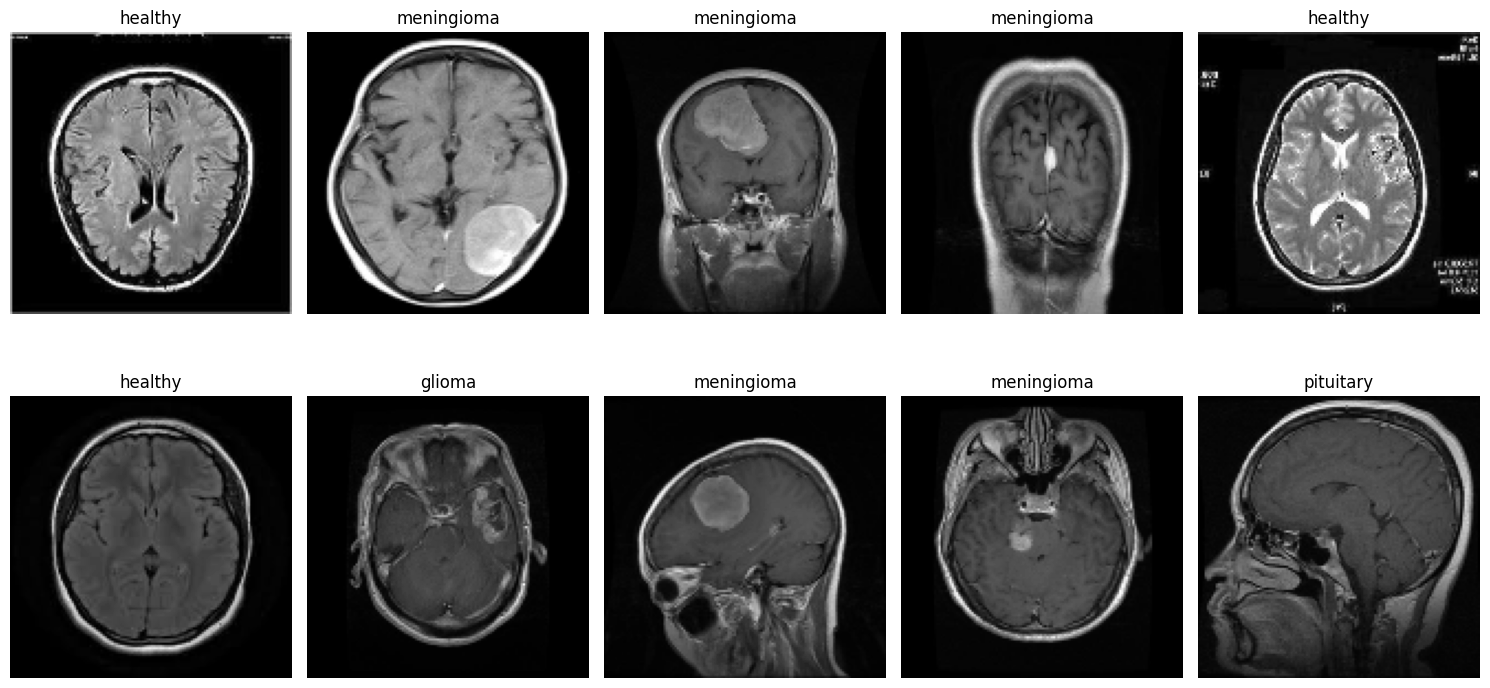

In [ ]:
import matplotlib.pyplot as plt
import random

num_images_to_display = 10
random_indices = random.sample(range(len(x_train)), num_images_to_display)

plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices):
  plt.subplot(2, 5, i + 1)
  plt.imshow(x_train[index].reshape(image_size[0], image_size[1]), cmap='gray')
  plt.title(categories[y_train[index]])
  plt.axis('off')

plt.tight_layout()
plt.show()

# **EXPERIMENTOS**

##**DNN**

In [ ]:
dnn_model = Sequential([
    Flatten(input_shape=(128, 128, 1)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

dnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

dnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,235,972 (16.16 MB)

 Trainable params: 4,235,972 (16.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

history = dnn_model.fit(
    x_train_split,
    y_train_split,
    epochs=15,
    validation_data=(x_test_split, y_test_split)
)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['loss'], label='Entrenamiento')
ax1.plot(history.history['val_loss'], label='Test')
ax1.set_title('Pérdida durante Entrenamiento y Testeo')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Pérdida')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Entrenamiento')
ax2.plot(history.history['val_accuracy'], label='Validación')
ax2.set_title('Exactitud durante Entrenamiento y Validación')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Exactitud')
ax2.legend()

plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


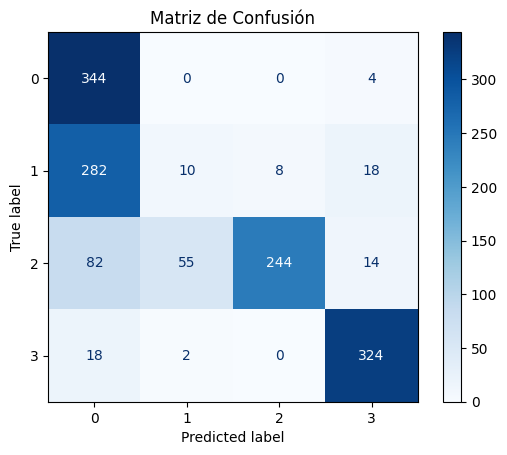

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred = np.argmax(model.predict(x_test_split), axis=1)

conf_matrix = confusion_matrix(y_test_split, y_pred)

ConfusionMatrixDisplay(conf_matrix).plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

## **LeNet**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf

lenet_model = Sequential([
    Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(128, 128, 1), padding='same'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=(5, 5), activation='relu', padding='valid'),
    AveragePooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(4, activation='softmax')
])

lenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lenet_model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 6)         │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 64, 64, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 30, 30, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 120)                 │       1,728,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │             340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,741,196 (6.64 MB)

 Trainable params: 1,741,196 (6.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

history_lenet = lenet_model.fit(
    x_train_split,
    y_train_split,
    epochs=15,
    validation_data=(x_test_split, y_test_split)
)

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.5855 - loss: 0.9157 - val_accuracy: 0.7879 - val_loss: 0.5086
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8491 - loss: 0.4095 - val_accuracy: 0.8584 - val_loss: 0.4256
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8994 - loss: 0.2895 - val_accuracy: 0.8811 - val_loss: 0.3084
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9255 - loss: 0.2048 - val_accuracy: 0.9181 - val_loss: 0.2196
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9642 - loss: 0.1202 - val_accuracy: 0.9302 - val_loss: 0.2063
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9603 - loss: 0.1027 - val_accuracy: 0.9324 - val_loss: 0.2103
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9677 - loss: 0.0894 - val_accuracy: 0.9345 - val_loss: 0.2021
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9755 - loss: 0.0622 - val_accuracy: 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9438 - loss: 0.2582
Test loss: 0.2899863123893738
Test accuracy: 0.9444839954376221


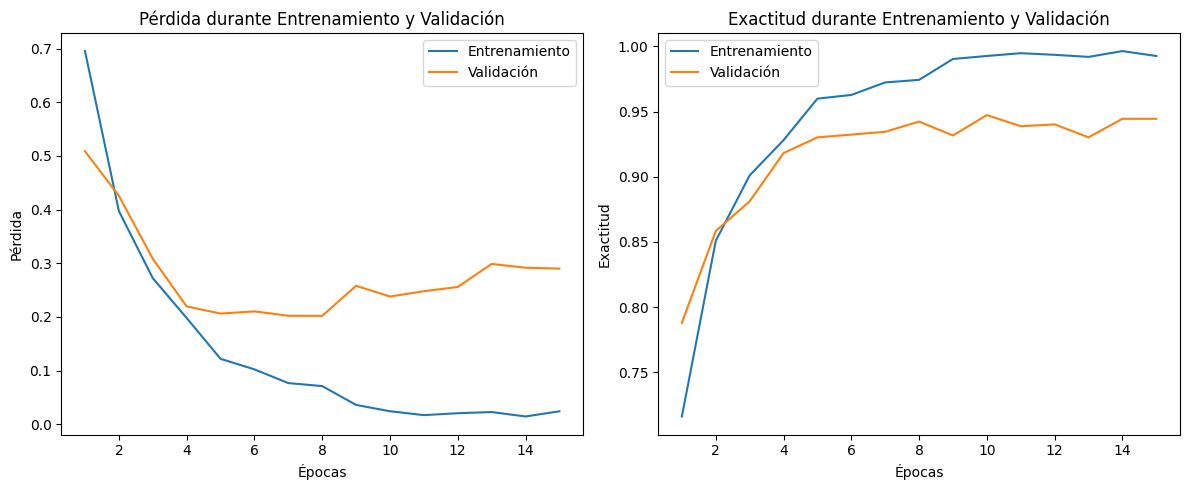

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

test_loss, test_accuracy = lenet_model.evaluate(x_test_split, y_test_split)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

train_loss = history_lenet.history['loss']
val_loss = history_lenet.history['val_loss']
train_accuracy = history_lenet.history['accuracy']
val_accuracy = history_lenet.history['val_accuracy']
epochs_range = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida durante Entrenamiento y Validación')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy, label='Entrenamiento')
plt.plot(epochs_range, val_accuracy, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.title('Exactitud durante Entrenamiento y Validación')
plt.legend()

plt.tight_layout()
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


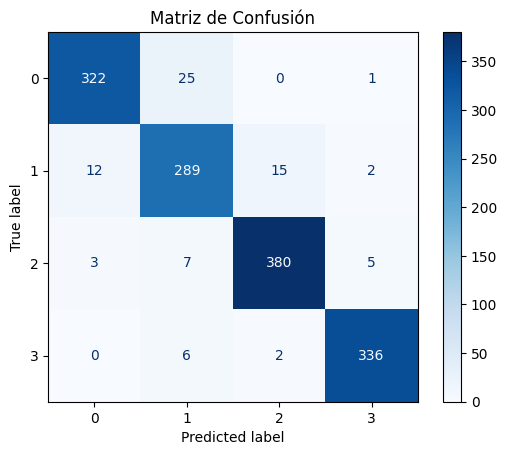

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred = np.argmax(lenet_model.predict(x_test_split), axis=1)

conf_matrix = confusion_matrix(y_test_split, y_pred)

ConfusionMatrixDisplay(conf_matrix).plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

## **CNN**

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,580 (12.61 MB)

 Trainable params: 3,304,580 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    x_train_split,
    y_train_split,
    epochs=15,
    validation_data=(x_test_split, y_test_split),
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.5766 - loss: 0.9557 - val_accuracy: 0.8384 - val_loss: 0.4462
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8230 - loss: 0.4561 - val_accuracy: 0.8470 - val_loss: 0.4098
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8684 - loss: 0.3495 - val_accuracy: 0.8847 - val_loss: 0.3138
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9005 - loss: 0.2731 - val_accuracy: 0.8989 - val_loss: 0.2458
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9181 - loss: 0.2035 - val_accuracy: 0.9068 - val_loss: 0.2474
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9387 - loss: 0.1636 - val_accuracy: 0.9338 - val_loss: 0.1909
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9517 - loss: 0.1233 - val_accuracy: 0.9281 - val_loss: 0.2039
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9644 - loss: 0.1038 - val_ac

44/44 - 1s - 12ms/step - accuracy: 0.9331 - loss: 0.1644

Test accuracy: 0.9330961108207703


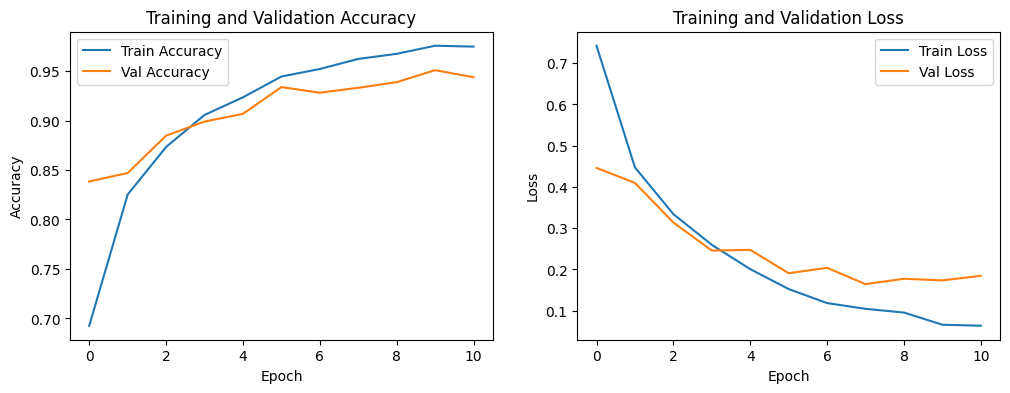

In [ ]:
test_loss, test_acc = model.evaluate(x_test_split, y_test_split, verbose=2)
print(f'\nTest accuracy: {test_acc}')

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")

plt.show()


In [ ]:
import numpy as np
y_pred = model.predict(x_test_split)
y_pred_classes = np.argmax(y_pred, axis=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_split, y_pred_classes)

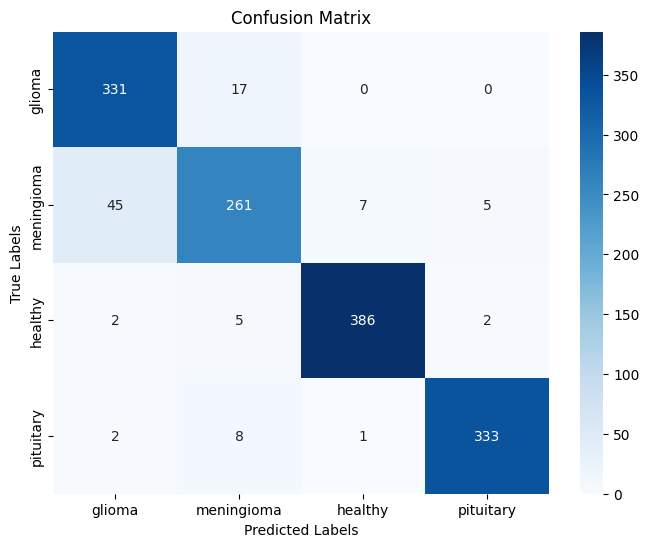

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = categories

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(x_test_split), axis=1)
print(classification_report(y_test_split, y_pred, target_names=categories))

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

      glioma       0.87      0.95      0.91       348
  meningioma       0.90      0.82      0.86       318
     healthy       0.98      0.98      0.98       395
   pituitary       0.98      0.97      0.97       344

    accuracy                           0.93      1405
   macro avg       0.93      0.93      0.93      1405
weighted avg       0.93      0.93      0.93      1405



MOVILNET


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,573,828 (13.63 MB)

 Trainable params: 1,315,844 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - accuracy: 0.6614 - loss: 0.8378 - val_accuracy: 0.8783 - val_loss: 0.3330
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8702 - loss: 0.3499 - val_accuracy: 0.9046 - val_loss: 0.2712
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8975 - loss: 0.2651 - val_accuracy: 0.9160 - val_loss: 0.2496
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9248 - loss: 0.2119 - val_accuracy: 0.9203 - val_loss: 0.2288
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9343 - loss: 0.1801 - val_accuracy: 0.9246 - val_loss: 0.2086
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9462 - loss: 0.1654 - val_accuracy: 0.9345 - val_loss: 0.1979
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9463 - loss: 0.1470 - val_accuracy: 0.9388 - val_loss: 0.1790
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9536 - loss: 0.1386 - val_ac

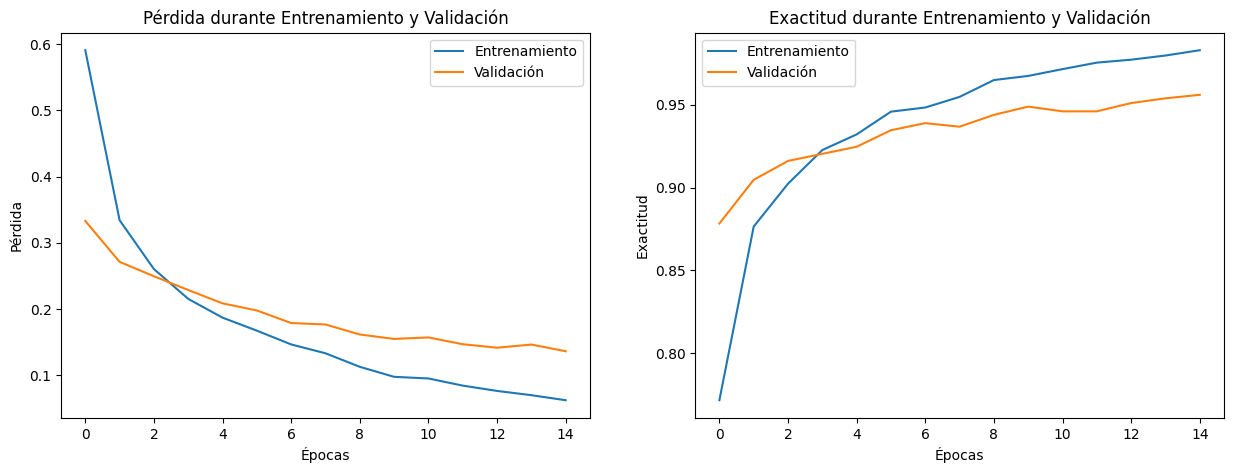

44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step


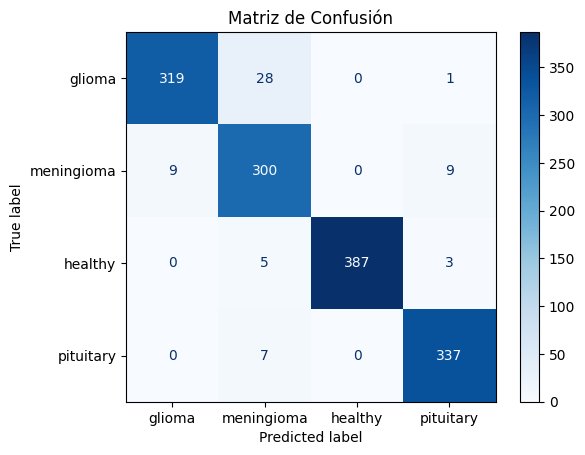

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os

base_dir = 'brain_tumor_mri_scans'
categories = ['glioma', 'meningioma', 'healthy', 'pituitary']
image_size = (128, 128)

x_train = []
y_train = []

for i, category in enumerate(categories):
    category_path = os.path.join(base_dir, category)
    for filename in os.listdir(category_path):
        img_path = os.path.join(category_path, filename)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, image_size)
            img = np.stack((img,)*3, axis=-1)
            x_train.append(img)
            y_train.append(i)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

x_train = np.array(x_train).astype('float32') / 255.0
y_train = np.array(y_train)

y_train = to_categorical(y_train, num_classes=4)

x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(
    x_train_split,
    y_train_split,
    epochs=15,
    batch_size=32,
    validation_data=(x_val_split, y_val_split)
)

val_loss, val_accuracy = model.evaluate(x_val_split, y_val_split, verbose=2)
print('\nValidation accuracy:', val_accuracy)

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['loss'], label='Entrenamiento')
ax1.plot(history.history['val_loss'], label='Validación')
ax1.set_title('Pérdida durante Entrenamiento y Validación')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Pérdida')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Entrenamiento')
ax2.plot(history.history['val_accuracy'], label='Validación')
ax2.set_title('Exactitud durante Entrenamiento y Validación')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Exactitud')
ax2.legend()

plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(model.predict(x_val_split), axis=1)
y_true = np.argmax(y_val_split, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

ConfusionMatrixDisplay(conf_matrix, display_labels=categories).plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

      glioma       0.97      0.92      0.94       348
  meningioma       0.88      0.94      0.91       318
     healthy       1.00      0.98      0.99       395
   pituitary       0.96      0.98      0.97       344

    accuracy                           0.96      1405
   macro avg       0.95      0.95      0.95      1405
weighted avg       0.96      0.96      0.96      1405



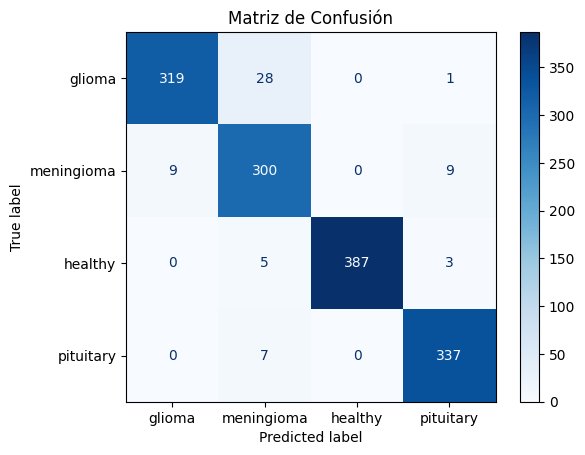

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(model.predict(x_val_split), axis=1)
y_true = np.argmax(y_val_split, axis=1)

print(classification_report(y_true, y_pred, target_names=categories))

conf_matrix = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=categories).plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

y_pred = np.argmax(model.predict(x_val_split), axis=1)
y_true = np.argmax(y_val_split, axis=1)

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy: 0.9559
Precision: 0.9575
Recall: 0.9559
F1 Score: 0.9562


In [ ]:
y_pred = np.argmax(model.predict(x_val_split), axis=1)
y_pred = np.argmax(dnn_model.predict(x_val_split), axis=1)
y_pred = np.argmax(lenet_model.predict(x_val_split), axis=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


NameError: name 'dnn_model' is not defined